In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
def trim(image):
    left = -1
    right = -1
    top = -1
    bottom = -1

    for i in range(image.shape[0]):
        if np.any(image[i] > 0):
            top = i
            break
    for i in range(image.shape[0] - 1, -1, -1):
        if np.any(image[i] > 0):
            bottom = i
            break
    for i in range(image.shape[1]):
        if np.any(image[:, i] > 0):
            left = i
            break
    for i in range(image.shape[1] - 1, -1, -1):
        if np.any(image[:, i] > 0):
            right = i
            break
    print(left, right, top, bottom)
    image = image[top:bottom, left:right]
    return image , left, right, top, bottom


In [2]:
testImagePaths = ['/Users/nuhash/Downloads/test13_53_2.PNG', '/Users/nuhash/Downloads/test18_50_25.PNG', '/Users/nuhash/Downloads/acne_breakouts.PNG']
maskImagePaths = ['/Users/nuhash/Downloads/test13_53_2.PNG', '/Users/nuhash/Downloads/test18_50_25.PNG', '/Users/nuhash/Downloads/test16_17_0.PNG']

660 1073 1613 1793
threshold_value 210.0
minVal 0.0 maxVal 241.0 minLoc (52, 15) maxLoc (273, 85)


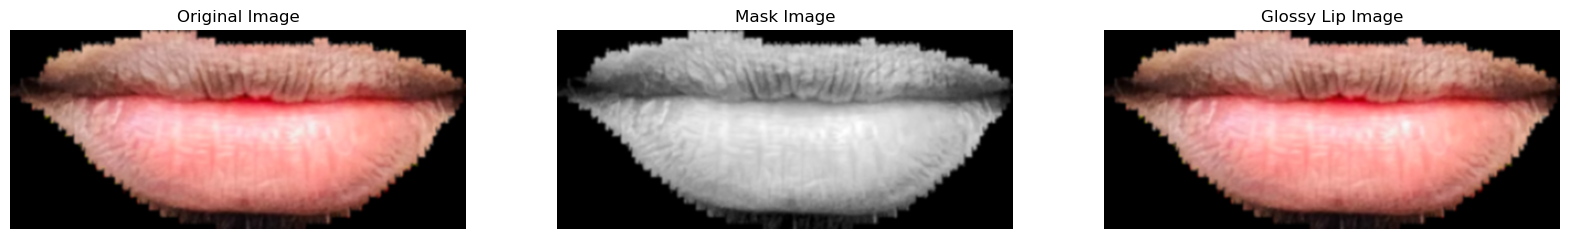

In [21]:
image, left, right, top, bottom = trim(cv2.imread(testImagePaths[0]))  # Replace with your image path
mask = (cv2.imread(maskImagePaths[0], cv2.IMREAD_GRAYSCALE))  # Replace with your mask path
mask = mask[top:bottom, left:right]


image = cv2.GaussianBlur(image, (5, 5), 0)
mask = cv2.GaussianBlur(mask, (5, 5), 0)


masked_image = cv2.bitwise_and(image, image, mask=mask)
gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

masked_pixels = gray_image[mask > 127]
threshold_value = np.percentile(masked_pixels, 90)
print("threshold_value", threshold_value)
_, lip_mask = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(gray_image, mask=mask)
print("minVal", minVal , "maxVal", maxVal, "minLoc", minLoc, "maxLoc", maxLoc)

center = maxLoc
radius = 5

lip_image = np.float32(image) / 255.0

overlay = np.zeros_like(lip_image)
rows, cols, _ = image.shape

for i in range(rows):
    for j in range(cols):
        distance = np.sqrt((i - center[1])**2 + (j - center[0])**2)
        intensity = max(0, 1 - (distance / radius))  # Create a radial gradient
        overlay[i, j] = [intensity * 0.9, intensity * 0.9, intensity * 0.9]  # Adjust color for gloss effect


overlay = cv2.GaussianBlur(overlay, (5,5), 0)

# overlay *= 0.5  # Adjust the intensity of the overlay

# Apply the glossy effect only to the lip region using the mask
glossy_image = lip_image * (1 - overlay) + overlay

lip_mask_3ch = cv2.merge([lip_mask, lip_mask, lip_mask]) / 255.0
glossy_lip_region = lip_image * (1 - lip_mask_3ch) + glossy_image * lip_mask_3ch
glossy_lip_image = np.uint8(glossy_lip_region * 255)

# plot the images
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(glossy_lip_image, cv2.COLOR_BGR2RGB))
plt.title("Glossy Lip Image")
plt.axis("off")

plt.show()
